In [1]:
import pandas as pd 
import numpy as np 
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [2]:
#Loading rating dataframe
column_names = ['User_ID', 'User_Names','Movie_ID','Rating','Timestamp']
movies_df = pd.read_csv(r"Movie_data.csv", sep = ',', names = column_names)
movies_df.head()

,User_ID,User_Names,Movie_ID,Rating,Timestamp
0,0,Shawn Wilson,50,5,881250949
1,0,Shawn Wilson,172,5,881250949
2,0,Shawn Wilson,133,1,881250949
3,196,Bessie White,242,3,881250949
4,196,Bessie White,393,4,881251863


In [3]:
#Loading the movie information
movie_title_df = pd.read_csv(r"Movie_Id_Titles.csv")
movie_title_df.rename(columns = {'item_id':'Movie_ID', 'title':'Movie_Title'}, inplace = True)
movie_title_df.head()

,Movie_ID,Movie_Title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [4]:
#Merging the dataframes
movies_df = pd.merge(movies_df,movie_title_df, on='Movie_ID')
movies_df.head()

,User_ID,User_Names,Movie_ID,Rating,Timestamp,Movie_Title
0,0,Shawn Wilson,50,5,881250949,Star Wars (1977)
1,0,Shawn Wilson,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,Shawn Wilson,133,1,881250949,Gone with the Wind (1939)
3,196,Bessie White,242,3,881250949,Kolya (1996)
4,196,Bessie White,393,4,881251863,Mrs. Doubtfire (1993)


# Exploring the dataset

In this project recommendation is made based on user similarities. The dataframe should have sufficient ratings from the users to to make good recommendations. 

In [5]:
movies_df.shape

(100003, 6)

In [6]:
movies_df.describe

<bound method NDFrame.describe of         User_ID     User_Names  Movie_ID  Rating  Timestamp  \
0             0   Shawn Wilson        50       5  881250949   
1             0   Shawn Wilson       172       5  881250949   
2             0   Shawn Wilson       133       1  881250949   
3           196   Bessie White       242       3  881250949   
4           196   Bessie White       393       4  881251863   
...         ...            ...       ...     ...        ...   
99998       941  Thomas Warren       919       5  875048887   
99999       941  Thomas Warren       273       3  875049038   
100000      941  Thomas Warren         1       5  875049144   
100001      941  Thomas Warren       294       4  875048532   
100002      941  Thomas Warren      1007       4  875049077   

                              Movie_Title  
0                        Star Wars (1977)  
1         Empire Strikes Back, The (1980)  
2               Gone with the Wind (1939)  
3                            Koly

In [7]:
#Minimum ratings per user
movies_df.groupby('User_ID')['Rating'].count().sort_values(ascending = True).head()

User_ID
0       3
166    20
418    20
34     20
441    20
Name: Rating, dtype: int64

In [8]:
#Getting no of unique users and movies
n_users = movies_df.User_ID.unique().shape[0]
n_movies = movies_df.Movie_ID.unique().shape[0]
n_users, n_movies

(944, 1682)

For collaborative recommendations, we need to see the relationship of every user with every movie based on ratings. 

In [9]:
movies_df['Movie_ID'].min(), movies_df['Movie_ID'].max()

(1, 1682)

In [10]:
movies_df['User_ID'].min(), movies_df['User_ID'].max()

(0, 943)

In [11]:
#Creating interaction matrix

#This would be a 2D array matrix to display user-movie_rating relationship
#Rows represent users by IDs, columns represent movies by IDs
ratings = np.zeros((n_users, n_movies))
for row in movies_df.itertuples():
    ratings[row[1], row[3]-1] = row[4]

# View the matrix
ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [12]:
ratings.shape[0]

944

In [13]:
# Calculate sparsity of the interaction matrix
# Density of the interaction matrix directly impacts quality of recommendations
# Sparsity is calculated by dividing the number of empty entries by the number of non-zero entries in the matrix.

sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
sparsity

6.298179628771237

In [14]:
# we use cosine similarity to find similarity among users
rating_cosine_similarity = cosine_similarity(ratings)


# Creating the Latent Factors

We start with initializing some parameters which will be a set of latent factors for each user and each movie.
Then we calculate our predictions, using dot product of each movie with each user.
After the predictions, we calculate the loss with the actual ratings. We are using mean squared error since this will help with providing measure of accuracy.
We can optimize our parameters using gradient descent to minimize the loss. 

At each step, the stochastic gradient descent optimizer will calculate the match between each movie and each user using the dot product, and will compare it to the actual rating that each user gave to each movie. It will then calculate the derivative of this value and will step the weights by multiplying this by the learning rate. Repeating this process over many iterations reduces the loss and improves the accuracy of the model, leading to better and better recommendations.

In [15]:
movies_df.head()

,User_ID,User_Names,Movie_ID,Rating,Timestamp,Movie_Title
0,0,Shawn Wilson,50,5,881250949,Star Wars (1977)
1,0,Shawn Wilson,172,5,881250949,"Empire Strikes Back, The (1980)"
2,0,Shawn Wilson,133,1,881250949,Gone with the Wind (1939)
3,196,Bessie White,242,3,881250949,Kolya (1996)
4,196,Bessie White,393,4,881251863,Mrs. Doubtfire (1993)


In [16]:
# We create DataLoaders object using from movies_df. By default, the first column is taken as the user, second column for item (Movie_Title) and third column for rating. We set these columns for dataloaders accordingly.
dls = CollabDataLoaders.from_df(movies_df, user_name='User_ID', item_name='Movie_Title', rating_name='Rating', bs=64)
dls.show_batch()

,User_ID,Movie_Title,Rating
0,192,"Truth About Cats & Dogs, The (1996)",2
1,256,Twister (1996),5
2,141,"Beautician and the Beast, The (1997)",3
3,303,"Mask, The (1994)",3
4,10,Psycho (1960),5
5,72,"Long Kiss Goodnight, The (1996)",5
6,361,"Usual Suspects, The (1995)",4
7,214,Down by Law (1986),4
8,160,Three Colors: Red (1994),4
9,883,"Fugitive, The (1993)",4


In [17]:
# Latent factors initialization
n_users  = len(dls.classes['User_ID'])
n_movies = len(dls.classes['Movie_Title'])
n_factors = 5 

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

To calculate the product of latent factors for each user and each movie, we need to look up the index of movie and and user for the user_factors and movie_factors table. We can do this by using replacing the indices with one-hot encoded vectors. But this will require more memory and time for storing and execution. We can instead use PyTorch library embedding.

Embedding: Multiplying by a one-hot-encoded matrix, using the computational shortcut that it can be implemented by simply indexing directly. The thing that you multiply the one-hot-encoded matrix by (or, using the computational shortcut, index into directly) is called the embedding matrix.

# Collaborative Filtering

In [18]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

The input of the model is a tensor of shape batch_size x 2, where the first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) contains the movie IDs. As explained before, we use the embedding layers to represent our matrices of user and movie latent factors:

In [19]:
x,y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 2]), torch.Size([64, 1]))

We create a Learner to optimize our model.

In [20]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [21]:
# fitting thw model
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.311678,1.324998,00:07
1,0.996799,1.084787,00:07
2,0.840962,0.951330,00:08
3,0.742550,0.882943,00:08
4,0.686632,0.863403,00:08


In [22]:
learn.show_results()

,User_ID,Movie_Title,Rating,Rating_pred
0,808,1489,4,3.778756
1,119,1480,5,5.581917
2,734,1241,4,3.590691
3,544,622,3,3.934627
4,304,1343,4,4.579803
5,406,1521,1,1.699957
6,270,42,3,3.355264
7,328,123,3,3.551941
8,776,1303,3,4.014628


In [23]:
preds, targs = learn.get_preds()
print("Max predicted rating:", preds.max().item())
print("Min predicted rating:", preds.min().item())

Max predicted rating: 6.139401435852051
Min predicted rating: -0.035346321761608124


We can see that this model predicts results which are out of range [0,5]. To improve this model, we can force the predictions to be between 0 and 5 ny using sigmoid_range.

In [24]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [25]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.943583,0.977225,00:08
1,0.657356,0.927866,00:08
2,0.476540,0.938231,00:07
3,0.368334,0.939033,00:07
4,0.311106,0.938175,00:07


In [26]:
preds, targs = learn.get_preds()
print("Max predicted rating:", preds.max().item())
print("Min predicted rating:", preds.min().item())

Max predicted rating: 5.3293867111206055
Min predicted rating: 0.5822687745094299


In previous predictions we only have weights for latent factors. This gives information about what kind of movie it is or what kind of kind of movies a user might like, e.g., sci-fy, action, etc. But there are some movies which are liked by most people and some are not. Likewise, there are some users who give max ratings for most of the movies, while some users usually give low ratings for most movies. To capture this information, we can use biases for each user and each movie.

In [27]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [28]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.873874,0.945900,00:08
1,0.597730,0.913048,00:07
2,0.419210,0.932302,00:07
3,0.308759,0.935997,00:07
4,0.303491,0.936568,00:07


The model starts getting worse near the end of training. Validation loss started increasing. This is a case of overfitting. To overcome this we can use weight decay/ L2 regularization. 

L2 regularization, consists in adding to your loss function the sum of all the weights squared, it will add a contribution to them that will encourage the weights to be as small as possible.

In [29]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.861376,0.935277,00:07
1,0.694173,0.877397,00:07
2,0.525595,0.859067,00:07
3,0.441798,0.840425,00:07
4,0.419633,0.837941,00:07


The loss has improved significantly.

In [30]:
# create DotProductBias without using the embedding library
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))
    
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [31]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.894547,0.945733,00:07
1,0.666468,0.889990,00:07
2,0.525140,0.871094,00:07
3,0.447204,0.852402,00:07
4,0.455321,0.847734,00:08


# Interpreting Embeddings and Biases

The model is able to provide movie recommendations for all users. Now we look at the paarmeters it has discovered. For interpreting the bias for movies, here are the movies with lowest values of bias vector:

In [32]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['Movie_Title'][i] for i in idxs]

['Mortal Kombat: Annihilation (1997)',
 'Children of the Corn: The Gathering (1996)',
 'Striptease (1996)',
 'Robocop 3 (1993)',
 'Big Bully (1996)']

What this shows is that for certain movies, even when a user’s latent factors align well with the movie’s (factors that often capture aspects such as action level, release era, or other characteristics), the users still tend not to enjoy them. While we could have simply ranked movies by their average rating, analyzing the learned bias reveals something more insightful. It highlights not just that a movie is generally unpopular, but that people tend to dislike it even when, based on their preferences, it seems like the kind of movie they should have enjoyed. Likewise, here are the movies with highest bias:

In [33]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['Movie_Title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Good Will Hunting (1997)',
 'Titanic (1997)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

In similar way, we can get users with lowest and highest values of bias vector.

In [34]:
user_bias = learn.model.user_bias.squeeze()
idxs = user_bias.argsort()[:5]
[dls.classes['User_ID'][i] for i in idxs]

[181, 405, 774, 445, 933]

In [35]:
idxs = user_bias.argsort(descending=True)[:5]
[dls.classes['User_ID'][i] for i in idxs]

[907, 507, 372, 472, 295]

Interpreting the embedding matrices directly is challenging because they contain too many factors to easily make sense of. However, we can apply a technique called Principal Component Analysis (PCA) to uncover the most important underlying directions in the embeddings. PCA helps reduce the complexity of the data while highlighting the dominant patterns that drive user and movie preferences.

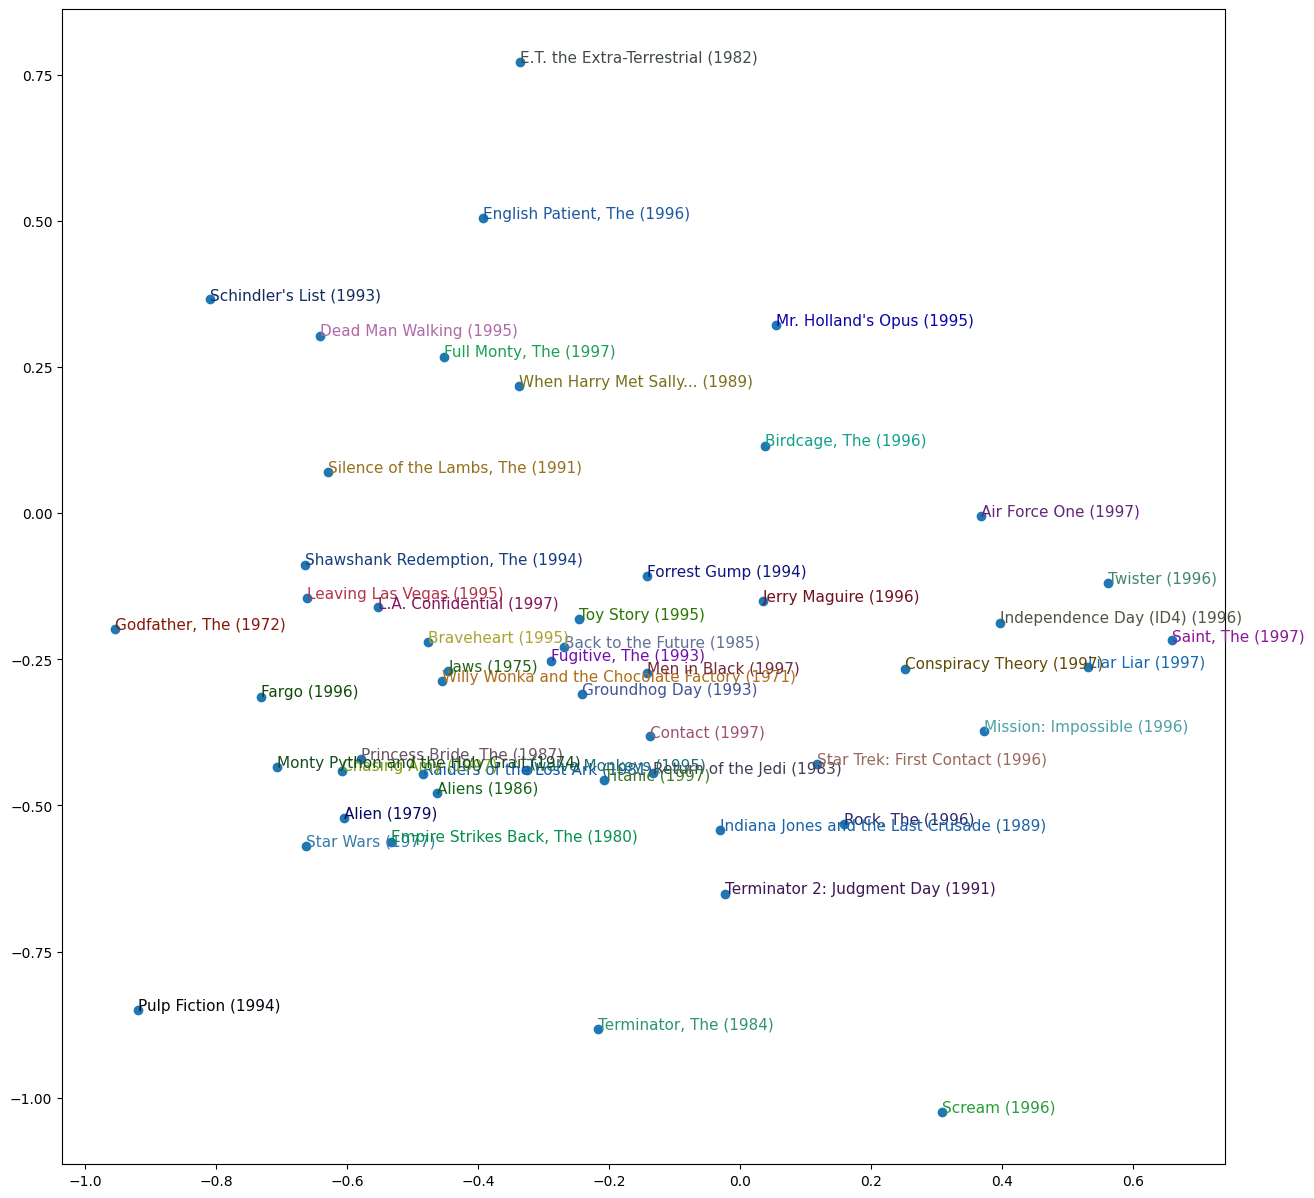

In [36]:
g = movies_df.groupby('Movie_Title')['Rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['Movie_Title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Using fastai.collab

In [37]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [38]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.892870,0.944062,00:07
1,0.673142,0.884706,00:07
2,0.527069,0.865653,00:07
3,0.473367,0.845488,00:07
4,0.430162,0.841136,00:07


In [39]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(945, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(945, 1)
  (i_bias): Embedding(1665, 1)
)

## Embedding Distance

## Measuring Movie Similarity with Embeddings  

In two dimensions, we measure the distance between two points using the Pythagorean theorem:  

$$
\sqrt{x^2 + y^2}
$$

where \(x\) and \(y\) are the differences along each axis. The same principle extends naturally to higher dimensions—such as a 50-dimensional embedding—where we sum the squared differences across all coordinates.  

In the context of **movie embeddings**, if two movies are very similar, their vectors will also be close in this high-dimensional space. This makes sense: users who enjoy one of these movies are very likely to enjoy the other as well.  

More generally, movie similarity can be defined by the overlap in the audiences who like them. The embedding distance provides a concrete way to measure this similarity.  

Using this idea, we can, for example, find the movie most similar to *Titanic (1997)* by identifying which embedding vector lies closest to it in the learned space.  


In [40]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['Movie_Title'].o2i['Titanic (1997)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['Movie_Title'][idx]

'Dark City (1998)'